In [1]:
from func import MyNet2, get_patient_loader
import torch
import torchvision.models as models
import zennit as zen
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.models.vgg import VGG
from torch.nn.modules.pooling import MaxPool2d, AdaptiveAvgPool2d
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from zennit.rules import Epsilon, AlphaBeta
from zennit.types import Linear
from zennit.core import Composite
from zennit.attribution import Gradient
from torchvision.models.resnet import ResNet
from torch.nn.modules.activation import ReLU
from torch.nn.modules.container import Sequential
from torch.nn.modules.conv import Conv2d
import os
from restructure import *

"""
different components to the other model
<class 'func.MyNet'>
<class 'torchvision.models.resnet.ResNet'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torchvision.models.resnet.Bottleneck'>
<class 'torch.nn.modules.batchnorm.BatchNorm1d'>
"""

# TODO: BatchNorm2d, Bottleneck, BatchNorm1d

/Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <D9493EF5-8DAB-3A5D-85D5-684F04544B84> /Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <7856C0E5-3D52-39C7-8515-71217150BD2E> /Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


24


"\ndifferent components to the other model\n<class 'func.MyNet'>\n<class 'torchvision.models.resnet.ResNet'>\n<class 'torch.nn.modules.batchnorm.BatchNorm2d'>\n<class 'torchvision.models.resnet.Bottleneck'>\n<class 'torch.nn.modules.batchnorm.BatchNorm1d'>\n"

In [34]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def get_res18(path):
    class Res18(nn.Module):
        def __init__(self, ciga):
            super(Res18, self).__init__()
            self.pretrained = ciga

            self.gene1 = nn.Sequential(nn.Linear(512, 200), nn.ReLU(), nn.Linear(200, 1))

        def forward(self, x):
            x = self.pretrained(x)
            x = self.gene1(x)
            return x

    ciga = models.resnet18()
    ciga.fc = torch.nn.Sequential()
    res18 = Res18(ciga)
    print(res18.load_state_dict(torch.load(path, map_location=torch.device('cpu'))))
    return(res18)

path = "../models/res18/res18_not_iced_e29.pt"
res18_no_ice = get_res18(path).to(device)
path = "../models/res18/RUBCNL_HLR_Res18_optim_ice/15072024_ep_29_lr_0.0005resnet.pt"
res18_ice    = get_res18(path).to(device)
res18_ice.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
path = "../models/res18/res18_iced_e29.pt"
res18    = get_res18(path).to(device)

"""
model = MyNet2(my_pretrained_model=models.resnet50(weights="IMAGENET1K_V2"))
path = "./data/05072024_single__5e-06resnet2.pt"
model.load_state_dict(torch.load(path))
model.eval()
model.to(device)

# model as a sequential for the restructuring
modules = []
modules.append(res18_no_ice.pretrained)
for layer in res18_no_ice.gene1:
    modules.append(layer)

sequential_no_ice = nn.Sequential(*modules)



modules = []
modules.append(res18_ice.pretrained)
for layer in res18_ice.gene1:
    modules.append(layer)

sequential_ice = nn.Sequential(*modules)
"""

data_dir = "../Training_Data"
patient = "/p009"
base_path = data_dir+patient+"/Preprocessed_STDataset/"
merge = pd.read_csv(base_path + "merge.csv")
merge.head()
loader = get_patient_loader(data_dir, patient)


<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [11]:
print(sequential_ice)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [4]:
model_copy = copy.deepcopy(sequential).to("cpu")
for i in range (1):
    input, target, name = get_img_target_name(loader,device,i)
    flood = find_a_ref(model_copy.to("cpu"), input.to("cpu"), y_ref=target.cpu(), method='flood', step_width=0.005, max_it=10e4, normalize_top=True)

In [3]:
def plot_relevance(att, filename = None):
    if filename is None:
        rel = att.sum(1).cpu()
    else:
        rel = torch.tensor(plt.imread(filename)).unsqueeze(0)
    # create an image of the visualize attribution
    img = zen.image.imgify(rel, symmetric=True, cmap='coldnhot')
    
    # show the image
    display(img)
    return img
    
def get_img_target_name(loader, device, tile_no):
    image, target, name = loader[tile_no]
    image = image.unsqueeze(0).to(device)
    image = image.float()
    target = torch.tensor(target[0]).to(device)
    return image, target, name


def get_coords_from_name(data_dir, patient, tile_name):
    base_path = data_dir+patient+"/Preprocessed_STDataset/"
    merge = pd.read_csv(base_path + "merge.csv")
    line = merge.loc[merge['tile'] == tile_name]
    x = line['x']
    y = line['y']
    return x, y


def relevance_and_plot(model, mapping_fn, composite, input = None):

    #composite = Composite(module_map=mapping_fn, canonizers=[canonizer])
    if input is None:
        input = torch.randn(1, 3, 224, 224).to(device)
    with Gradient(model, composite) as attributor:
        out, grad = attributor(input)
    imshow = input.to('cpu').squeeze().numpy().sum(axis=0)
    plt.imshow(imshow)
    plot_relevance(grad)
    print("out: ", out)

In [9]:
for i in range(len(out_target)):
    with open("./xai_log.txt", "a") as f:
        out, grad, target, name = out_target[i]
        s = "out: " + str(out.item()) + ", target: " + str(target.item()) + ", filename " + name.replace("//", "/") + "\n"
        f.write(s)
        plot_relevance(grad) 
        img = plt.imread(name)
        plt.imshow(img)
        plt.show()
        
        print(s)

In [37]:
from restructure import find_a_ref, restructure_model
import copy
composite = zen.composites.EpsilonPlusFlat(canonizers=[zen.torchvision.ResNetCanonizer()])
out_target = []
model = res18_no_ice
for i in range(20):
    input, target, name = get_img_target_name(loader,device,i)
    model_copy = copy.deepcopy(model)
    x, y = get_coords_from_name(data_dir,patient,os.path.basename(name))
    #ref = find_a_ref(model_copy)
    gene1 = restructure_model(model_copy.gene1, torch.tensor(0), in_layer=-3, out_layer=-1)
    model_copy.gene1 = gene1
    model_copy.to(device)
    with Gradient(model, composite) as attributor:
        out, grad = attributor(input)
        if grad.count_nonzero() == 0:
            continue
    out_orig = model(input)
    """
    model_copy = copy.deepcopy(sequential_ice).to("cpu")
    #model_copy.to(device)

    flood = find_a_ref(model_copy, input.to("cpu"), y_ref=0, method='flood', step_width=0.005, max_it=10e4, normalize_top=False)
    #ref = find_a_ref(model_copy)
    gene1 = restructure_model(model_copy, flood, in_layer=-3, out_layer=-1)
    model_copy.gene1 = gene1
    model_copy.to(device)
    with Gradient(model_copy, composite) as attributor:
        out_flood0, grad_flood0 = attributor(input)
        if grad_cpy.count_nonzero() == 0:
            continue
            
    model_copy = copy.deepcopy(sequential_no_ice)
    model_copy.to(device)
    
    flood = find_a_ref(model_copy, input, y_ref=target, method='flood', step_width=0.005, max_it=10e4, normalize_top=False)
    #ref = find_a_ref(model_copy)
    gene1 = restructure_model(model_copy.gene1, flood, in_layer=-3, out_layer=-1)
    model_copy.gene1 = gene1
    model_copy.to(device)
    with Gradient(model_copy, composite) as attributor:
        out_flood_tar, grad_flood_tar = attributor(input)
        if grad_cpy.count_nonzero() == 0:
            continue
    
    with Gradient(model, composite) as attributor:
        out_ori, grad_ori = attributor(input)
        if grad_ori.count_nonzero() == 0:
            continue
    """
    
    out_target.append((out, out_orig, grad, target, x, y, name))

images = []
coords = []
for i in range(len(out_target)):
    with open("./xai_log.txt", "a") as f:
        out, out_orig, grad, target, x, y, name = out_target[i]
        s = "out: " + str(out.item()) + ", out_orig: " + str(out_orig.item()) + ", target: " + str(target.item()) + ", filename: " + os.path.basename(name.replace("//", "/")) + "\n"
        f.write(s)
        #plot_relevance(grad)
        
        #img = plt.imread(name)
        #images.append(img)
        #coords.append([x-112,x+112,y-112,y+112])
        #plt.imshow(img)
        #plt.show()
        
        print(s)

out: -0.12255256623029709, out_orig: -0.07183544337749481, target: -0.1566115766763687, filename: p009_72_0.tiff

out: -0.0009207874536514282, out_orig: -0.06663620471954346, target: -0.33355867862701416, filename: p009_73_0.tiff

out: -0.025556311011314392, out_orig: -0.06566643714904785, target: -7.824455678928643e-05, filename: p009_74_0.tiff

out: -0.014656178653240204, out_orig: -0.02692045271396637, target: -0.7764939665794373, filename: p009_75_0.tiff

out: -0.06791572272777557, out_orig: -0.040368545800447464, target: 0.14026819169521332, filename: p009_76_0.tiff

out: -0.08436466753482819, out_orig: -0.07824289798736572, target: -7.824455678928643e-05, filename: p009_77_0.tiff

out: -0.054173171520233154, out_orig: -0.06115890294313431, target: 0.26746365427970886, filename: p009_78_0.tiff

out: -0.012269746512174606, out_orig: -0.04143543541431427, target: 0.14026819169521332, filename: p009_79_0.tiff

out: -0.09131471067667007, out_orig: -0.04913434013724327, target: -0.5370

TypeError: Invalid shape (3, 224, 224) for image data

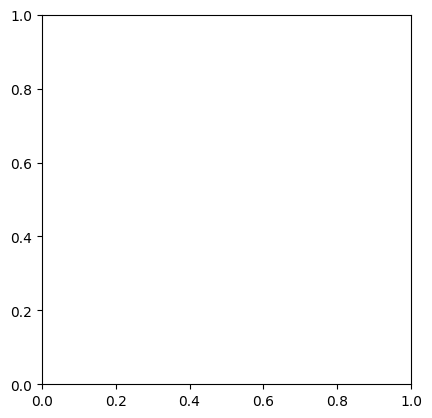

In [13]:
for i in range(20):
    input, target, name = get_img_target_name(loader,device,i)
    plt.imshow(input.to("cpu").squeeze())
    plt.show()

In [ ]:


for extend, img in zip(coords, images):
    ax.imshow(img, extend=extend)

In [45]:
model_copy.to(device)
y_t_ = model_copy.forward(input)
a_ref_ = model_copy[:-1](input)
b_ref_ = model_copy(input)[:-1]
c_ref_ = model_copy(input)



print(a_ref_)
print(b_ref_)
print(c_ref_)
print(c_ref_[:-1])
xxx = ["a"]
print(xxx[:-1] and xxx[-1])

#print(y_t_.item(), " ", a_ref_.item())
#model_copy

In [10]:
log = False
def module_map_orig(ctx, name, module):
    # check whether there is at least one child, i.e. the module is not a leaf
    try:
        next(module.children())
    except StopIteration:
        # StopIteration is raised if the iterator has no more elements,
        # which means in this case there are no children and module is a leaf
        pass
    else:
        # if StopIteration is not raised on the first element, module is not a leaf
        return None

    # if the module is not Linear, we do not want to assign a hook
    if not isinstance(module, Linear):
        return None

    # count the number of the leaves processed yet in 'leafnum'
    if 'leafnum' not in ctx:
        ctx['leafnum'] = 0
    else:
        ctx['leafnum'] += 1

    # the first 10 leaf-modules which are of type Linear should be assigned
    # the Alpha2Beta1 rule
    if ctx['leafnum'] < 10:
        if log:
            print(type(module), " -> AlphaBeta(alpha=2, beta=1)")
        return AlphaBeta(alpha=2, beta=1)
    if log:
        print(type(module), " -> Epsilon(epsilon=1e-3)")
    # all other rules should be assigned Epsilon
    return Epsilon(epsilon=1e-3)


def module_map_debug(ctx, name, module):
    if type(module) is MyNet:             return None
    if type(module) is ResNet:            return None
    if type(module) is ReLU:              return None
    if type(module) is Sequential:        return None
    if type(module) is VGG:               return None
    if type(module) is MaxPool2d:         return None
    if type(module) is Dropout:           return None
    if type(module) is AdaptiveAvgPool2d: return None
    
    if type(module) is Conv2d:            return Epsilon(epsilon=1e-3)
    if type(module) is Linear:
        # count the number of the leaves processed yet in 'leafnum'
        if 'leafnum' not in ctx:
            ctx['leafnum'] = 0
        else:
            ctx['leafnum'] += 1
        if ctx['leafnum'] < 10:
            if log:
                print(type(module), " -> AlphaBeta(alpha=2, beta=1)")
            return AlphaBeta(alpha=2, beta=1)
        if log:
            print(type(module), " -> Epsilon(epsilon=1e-3)")
        return Epsilon(epsilon=1e-3)
    
    # check whether there is at least one child, i.e. the module is not a leaf
    try:
        next(module.children())
    except StopIteration:
        # StopIteration is raised if the iterator has no more elements,
        # which means in this case there are no children and module is a leaf
        pass
    else:
        if log:
            print(type(module), " -> None")
        # if StopIteration is not raised on the first element, module is not a leaf
        return None
    if log:
        print(type(module), " isinstance(Linear): ", isinstance(module, Linear))
    # if the module is not Linear, we do not want to assign a hook
    if not isinstance(module, Linear):
        if log:
            print(type(module), " -> None")
        return None

    return None
def module_map_my_net_debug(ctx, name, module):
    if type(module) is MyNet:      return None
    if type(module) is ResNet:     return None
    if type(module) is ReLU:       return None
    if type(module) is Sequential: return None
    
    if type(module) is Conv2d:     return Epsilon(epsilon=1e-3)
    
    
    
    
    # check whether there is at least one child, i.e. the module is not a leaf
    try:
        next(module.children())
    except StopIteration:
        # StopIteration is raised if the iterator has no more elements,
        # which means in this case there are no children and module is a leaf
        pass
    else:
        if log:
            print(type(module), " -> None")
        # if StopIteration is not raised on the first element, module is not a leaf
        return None
    # if the module is not Linear, we do not want to assign a hook
    if not isinstance(module, Linear):
        if log:
            print(type(module), " -> None")
        return None

    # count the number of the leaves processed yet in 'leafnum'
    if 'leafnum' not in ctx:
        ctx['leafnum'] = 0
    else:
        ctx['leafnum'] += 1

    # the first 10 leaf-modules which are of type Linear should be assigned
    # the Alpha2Beta1 rule
    if ctx['leafnum'] < 10:
        if log:
            print("leafnum ", ctx['leafnum'], type(module) , " -> AlphaBeta(alpha=2, beta=1)")
        return AlphaBeta(alpha=2, beta=1)
    if log:
        print(type(module), " -> Epsilon(epsilon=1e-3)")
    # all other rules should be assigned Epsilon
    return Epsilon(epsilon=1e-3)

In [ ]:
print(grad.shape)
print(grad.squeeze().shape)
r = plt.imread(filename)
print(r.shape)
plot_relevance(None, filename)

In [ ]:
for i in range (len(out_target)):
    out, grad, target, name = out_target[i]
    print(target)

In [ ]:
out, grad, target, name = out_target[1]
print(name)

In [ ]:
class ResNetCanonizer(zen.torchvision.CompositeCanonizer):
    '''Canonizer for torchvision.models.resnet* type models. This applies SequentialMergeBatchNorm, as well as
    add a Sum module to the Bottleneck modules and overload their forward method to use the Sum module instead of
    simply adding two tensors, such that forward and backward hooks may be applied.'''

    def __init__(self):
        super().__init__((
            zen.torchvision.SequentialMergeBatchNorm(),
            zen.torchvision.ResNetBottleneckCanonizer(),
            zen.torchvision.ResNetBasicBlockCanonizer(),
        ))

In [ ]:
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
model_drop = models.resnet50(pretrained=True)
print(newmodel)

In [13]:
vgg = models.vgg16()
res = models.resnet50()
current_model = res18_ice
img, target, filename = get_img_target_name(loader, device, 2)

can_res = zen.torchvision.ResNetCanonizer()
composite = zen.composites.EpsilonPlusFlat(canonizers=[can_res])

out_target = []
for i in range(20):
    input, target, name = get_img_target_name(loader,device,i)
    with Gradient(current_model, composite) as attributor:
        out, grad = attributor(input)
        if grad.count_nonzero() == 0:
            continue
        out_target.append((out, grad, target, name))


#relevance_and_plot(current_model.to(device), module_map_debug, composite, img)
#print("target: ", target)

In [8]:
vgg = models.vgg16()
res = models.resnet50()
current_model = res18_ice
img, target, filename = get_img_target_name(loader, device, 2)

can_res = zen.torchvision.ResNetCanonizer()
composite = zen.composites.EpsilonPlusFlat(canonizers=[can_res])

out_target = []
for i in range(20):
    input, target, name = get_img_target_name(loader,device,i)
    with Gradient(model, composite) as attributor:
        out, grad = attributor(input)
        if grad.count_nonzero() == 0:
            continue
        out_target.append((out, grad, target, name))


#relevance_and_plot(current_model.to(device), module_map_debug, composite, img)
#print("target: ", target)

In [7]:
out_target = []
for i in range(20):
    input, target, name = get_img_target_name(loader,device,i)
    with Gradient(sequential, composite) as attributor:
        out, grad = attributor(input)
        if grad.count_nonzero() == 0:
            continue
        out_target.append((out, grad, target, name))